In [1]:
import pandas as pd
import os
from sodapy import Socrata
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import acquire
import prepare
import explore
import wrangle

pd.set_option('display.max_column', None)
# plotting defaults
plt.rc('figure', figsize=(23, 10))
plt.style.use('seaborn-dark-palette')
plt.rc('font', size=16)

# Acquire and Prepare the Dta
We'll use the wrangle module to acquire and prepare the data in one step

In [2]:
df = wrangle.wrangle_crime_data()

Using cached csv


In [3]:
print(df.shape)
df.head()

(349581, 18)


,crime_type,family_violence,occurrence_time,occurrence_date,report_time,report_date,location_type,address,zip_code,council_district,sector,district,latitude,longitude,clearance_status,clearance_date,cleared,time_to_report
34573,ASSAULT ON PUBLIC SERVANT,N,2021-12-31 23:50:00,2021-12-31,2021-12-31 23:50:00,2021-12-31,COMMERCIAL / OFFICE BUILDING,111 CONGRESS AVE,78701.0,9.0,GE,3,30.263739,-97.743651,cleared by arrest,2022-01-03,True,0 days 00:00:00
34574,THEFT,N,2021-12-31 23:50:00,2021-12-31,2022-01-07 14:12:00,2022-01-07,OTHER / UNKNOWN,6936 E BEN WHITE BLVD SVRD WB,78741.0,3.0,HE,5,30.215264,-97.703019,not cleared,2022-01-10,False,6 days 14:22:00
34575,PUBLIC INTOXICATION,N,2021-12-31 23:50:00,2021-12-31,2021-12-31 23:50:00,2021-12-31,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,406 E 6TH ST,78701.0,9.0,GE,2,30.267300,-97.738857,cleared by arrest,2021-12-31,True,0 days 00:00:00
34576,DOC DISCHARGE GUN - PUB PLACE,N,2021-12-31 23:47:00,2021-12-31,2021-12-31 23:47:00,2021-12-31,RESIDENCE / HOME,1202 E ST JOHNS AVE,78752.0,4.0,ID,1,30.328049,-97.693683,not cleared,2022-01-05,False,0 days 00:00:00
34577,AGG ASLT STRANGLE/SUFFOCATE,Y,2021-12-31 23:40:00,2021-12-31,2022-01-01 00:44:00,2022-01-01,RESIDENCE / HOME,10000 N LAMAR BLVD,78758.0,4.0,ED,1,30.369262,-97.695105,not cleared,2022-01-05,False,0 days 01:04:00


# Explore the Distributions of the Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349581 entries, 34573 to 436548
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype          
---  ------            --------------   -----          
 0   crime_type        349581 non-null  object         
 1   family_violence   349581 non-null  object         
 2   occurrence_time   349581 non-null  datetime64[ns] 
 3   occurrence_date   349581 non-null  datetime64[ns] 
 4   report_time       349581 non-null  datetime64[ns] 
 5   report_date       349581 non-null  datetime64[ns] 
 6   location_type     349581 non-null  object         
 7   address           349581 non-null  object         
 8   zip_code          349581 non-null  float64        
 9   council_district  349581 non-null  float64        
 10  sector            349581 non-null  object         
 11  district          349581 non-null  object         
 12  latitude          349581 non-null  float64        
 13  longitude         349581 non-null  float

In [5]:
# Use .describe with object columns
obj_cols = df.columns[[df[col].dtype == 'O' for col in df.columns]]
obj_cols

for col in obj_cols:
    print(col.upper())
    print('Count:')
    print(df[col].value_counts())
    print('\n')
    print('Proportions:')
    print(df[col].value_counts(normalize=True, dropna=False))
    print('--------------------------')
    print('\n')


CRIME_TYPE
Count:
BURGLARY OF VEHICLE               34886
THEFT                             29943
FAMILY DISTURBANCE                24386
CRIMINAL MISCHIEF                 19382
ASSAULT W/INJURY-FAM/DATE VIOL    12857
                                  ...  
COMMERCIAL BRIBERY                    1
ATT BURGLARY OF RESIDENCE             1
SALE OF DXM TO MINOR                  1
MANF SYNTHETIC MARIJUANA              1
BAIL JUMPING/FAIL TO APPEAR           1
Name: crime_type, Length: 341, dtype: int64


Proportions:
BURGLARY OF VEHICLE               0.099794
THEFT                             0.085654
FAMILY DISTURBANCE                0.069758
CRIMINAL MISCHIEF                 0.055444
ASSAULT W/INJURY-FAM/DATE VIOL    0.036778
                                    ...   
COMMERCIAL BRIBERY                0.000003
ATT BURGLARY OF RESIDENCE         0.000003
SALE OF DXM TO MINOR              0.000003
MANF SYNTHETIC MARIJUANA          0.000003
BAIL JUMPING/FAIL TO APPEAR       0.000003
Name: crim

In [6]:
df.council_district.value_counts()

9.0     56374
3.0     51663
4.0     48615
7.0     39888
1.0     39585
2.0     33606
5.0     28417
6.0     20494
10.0    16128
8.0     14811
Name: council_district, dtype: int64

# Split the Data for Exploratation

In [7]:
train, validate, test = prepare.split_data(df)
train.shape, validate.shape, test.shape

((195764, 18), (83900, 18), (69917, 18))

In [8]:
train_copy = train.copy()

# Copy of Train and adding GeoPandas

In [9]:
#Assign my .shp file to a variable named “asutin_map”
austin_map = gpd.read_file('Boundaries_zipcode/geo_export_9b5aa23d-57b1-41f4-b4f9-0a9d97fac540.shp')

In [10]:
austin_map = austin_map.drop(columns =['affgeoid10','geoid10','aland10','awater10'])

In [11]:
austin_map = austin_map.rename(columns ={'zcta5ce10': 'zip_code'})
austin_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zip_code  54 non-null     object  
 1   geometry  54 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 992.0+ bytes


In [12]:
austin_map['zip_code'] = austin_map.zip_code.astype('float64')

In [14]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195764 entries, 128272 to 382883
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype          
---  ------            --------------   -----          
 0   crime_type        195764 non-null  object         
 1   family_violence   195764 non-null  object         
 2   occurrence_time   195764 non-null  datetime64[ns] 
 3   occurrence_date   195764 non-null  datetime64[ns] 
 4   report_time       195764 non-null  datetime64[ns] 
 5   report_date       195764 non-null  datetime64[ns] 
 6   location_type     195764 non-null  object         
 7   address           195764 non-null  object         
 8   zip_code          195764 non-null  float64        
 9   council_district  195764 non-null  float64        
 10  sector            195764 non-null  object         
 11  district          195764 non-null  object         
 12  latitude          195764 non-null  float64        
 13  longitude         195764 non-null  floa

In [15]:
#create a new dataframe with both our geographical and statistical data in it by merging our two tables together.
new_df = austin_map.merge(train_copy, on ='zip_code')

In [16]:
new_df.to_csv('Geo_Crime_Reports.csv')

In [15]:
new_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 349574 entries, 0 to 349573
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   zip_code          349574 non-null  float64       
 1   geometry          349574 non-null  geometry      
 2   crime_type        349574 non-null  object        
 3   family_violence   349574 non-null  object        
 4   occurrence_time   349574 non-null  datetime64[ns]
 5   occurrence_date   349574 non-null  datetime64[ns]
 6   report_time       349574 non-null  datetime64[ns]
 7   report_date       349574 non-null  datetime64[ns]
 8   location_type     349574 non-null  object        
 9   address           349574 non-null  object        
 10  council_district  349574 non-null  float64       
 11  sector            349574 non-null  object        
 12  district          349574 non-null  object        
 13  latitude          349574 non-null  float64       
 

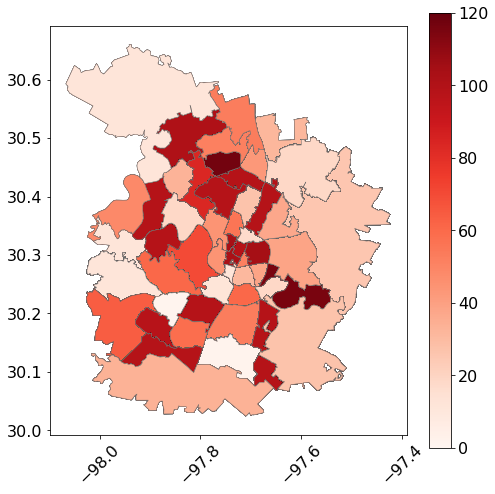

In [25]:
#Crime_type by zip_code
fig, ax = plt.subplots(1, figsize=(8, 8))
plt.xticks(rotation=45)
new_df.plot(column="crime_type", cmap="Reds", linewidth=0.4, ax=ax, edgecolor=".4")
bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=120))
bar_info._A = []
cbar = fig.colorbar(bar_info)

# Continuing exploration on Train

In [167]:
train[train.crime_type == 'PUBLIC INTOXICATION'].value_counts()

crime_type           family_violence  occurrence_time      occurrence_date  report_time          report_date  location_type                         address                  zip_code  council_district  sector  district  latitude   longitude   clearance_status   clearance_date  cleared  counts
PUBLIC INTOXICATION  N                2019-08-13 22:33:00  2019-08-13       2019-08-13 22:33:00  2019-08-13   BAR / NIGHTCLUB                       6900 N FM 620 RD         78732.0   6.0               AD      8         30.402582  -97.855216  cleared by arrest  2019-08-14      True     11376     2
                                      2018-01-01 02:21:00  2018-01-01       2018-01-01 02:21:00  2018-01-01   HWY / ROAD / ALLEY/ STREET/ SIDEWALK  314 E 6TH ST             78701.0   9.0               GE      2         30.267526  -97.739719  cleared by arrest  2018-01-01      True     31596     1
                                      2020-02-08 01:40:00  2020-02-08       2020-02-08 01:40:00  2020-02-08   H

In [180]:
train[train.family_violence == 'True'].cleared.value_counts()

Series([], Name: cleared, dtype: int64)

## crime type exploration

- murders - 85 total, 8 capital murders in set the rest are murders
- 2061 public intoxications
- 15.5k family violence reports

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195764 entries, 128272 to 382883
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   crime_type        195764 non-null  object        
 1   family_violence   195764 non-null  object        
 2   occurrence_time   195764 non-null  datetime64[ns]
 3   occurrence_date   195764 non-null  datetime64[ns]
 4   report_time       195764 non-null  datetime64[ns]
 5   report_date       195764 non-null  datetime64[ns]
 6   location_type     195764 non-null  object        
 7   address           195764 non-null  object        
 8   zip_code          195764 non-null  float64       
 9   council_district  195764 non-null  float64       
 10  sector            195764 non-null  object        
 11  district          195764 non-null  object        
 12  latitude          195764 non-null  float64       
 13  longitude         195764 non-null  float64       
 14 

In [18]:
train.council_district.value_counts()

9.0     31596
3.0     28789
4.0     27418
7.0     22483
1.0     22055
2.0     18698
5.0     16014
6.0     11376
10.0     9010
8.0      8325
Name: council_district, dtype: int64

### General takeaways
- total of 195K rows of crime
- district 9 has highest count at 31k
    - UT campus, 6th Street, Rainey Street, capital
- district 3/4 have roughly the same at 28k
    - district 3 - ladybird lake, ACC
- district 7/1 have 22k each of crime
- district 2/5 have about 17k
- district 6/10/8 have the lowest counts by far
    - 'west' austin, more on the outskirts
    - district 8 - zilker park, barton springs pool
    - district 10 - lake travis, westlake
    - district 6 - borders cedar park
    
- Seasonality
- SXSW - March
- ACL - October
- School - STARTS late August | ENDS Early December
            STARTS early January | ENDS Late May


#### What kind of crime is in each district?

In [19]:
train.council_district.value_counts()

9.0     31596
3.0     28789
4.0     27418
7.0     22483
1.0     22055
2.0     18698
5.0     16014
6.0     11376
10.0     9010
8.0      8325
Name: council_district, dtype: int64

In [20]:
one = train[train.council_district == 1]
two = train[train.council_district == 2]
three = train[train.council_district == 3]
four = train[train.council_district == 4]
five = train[train.council_district == 5]
six = train[train.council_district == 6]
seven = train[train.council_district == 7]
eight = train[train.council_district == 8]
nine = train[train.council_district == 9]
ten = train[train.council_district == 10]


one.shape, two.shape, three.shape, four.shape, five.shape, six.shape, seven.shape, eight.shape, nine.shape, ten.shape

((22055, 17),
 (18698, 17),
 (28789, 17),
 (27418, 17),
 (16014, 17),
 (11376, 17),
 (22483, 17),
 (8325, 17),
 (31596, 17),
 (9010, 17))

In [21]:
# district 9 has the most crime
nine.crime_type.value_counts()

THEFT                            3119
BURGLARY OF VEHICLE              2990
ASSAULT BY CONTACT               1650
CRIMINAL MISCHIEF                1643
ASSAULT WITH INJURY              1414
                                 ... 
ASSAULT - SCHOOL PERSONNEL          1
REPEAT RUNAWAY                      1
TRUANCY                             1
AGG PROMOTION OF PROSTITUTION       1
MANSLAUGHTER                        1
Name: crime_type, Length: 260, dtype: int64

In [91]:
# district 3 is also in downtown, looking at the crime type
three.crime_type.value_counts()

THEFT                             2544
BURGLARY OF VEHICLE               2507
FAMILY DISTURBANCE                1973
CRIMINAL MISCHIEF                 1593
ASSAULT W/INJURY-FAM/DATE VIOL    1099
                                  ... 
PROBATION VIOL                       1
HINDER SECURED CREDITORS             1
MANF CONTROLLED SUB- SYN NARC        1
JUSTIFIED HOMICIDE                   1
BOMB THREAT                          1
Name: crime_type, Length: 244, dtype: int64

In [92]:
# district 8 is west austin, looking at crime type
eight.crime_type.value_counts()

BURGLARY OF VEHICLE               1135
THEFT                              891
FAMILY DISTURBANCE                 391
CRIMINAL MISCHIEF                  351
THEFT BY SHOPLIFTING               346
                                  ... 
FORGERY OF IDENTIFICATION            1
AGG ROBBERY BY ASSAULT               1
INTERFERENCE PUBLIC DUTIES           1
TERRORISTIC THREAT-MASS CASLTY       1
UNLAWFUL RESTRAINT                   1
Name: crime_type, Length: 184, dtype: int64

In [93]:
# district 10 is more closer to lake travis, second lowest crime count
ten.crime_type.value_counts()

BURGLARY OF VEHICLE            1793
THEFT                           715
CRIMINAL MISCHIEF               501
FAMILY DISTURBANCE              440
IDENTITY THEFT                  375
                               ... 
POSS DANG DRUG                    1
RETALIATION                       1
ASSAULT OF A PREGNANT WOMAN       1
REPEAT RUNAWAY                    1
CAPITAL MURDER                    1
Name: crime_type, Length: 182, dtype: int64

## Districts and their level of crime in descending order
### Questions for Ryan
- What does it mean for the case to not be cleared
-- not cleared means charge has not been given yet. not enough evidence to be charged
-- cleared by exception doesn't mean it was ended in arrest. person could have died
-- cleared by arrest
- Did he notice seasonality trends
- pre/post covid numbers
-- family violence pre and post pandemic
-- what days are higher in family violence
- single incident top charge
-- 

In [99]:
train.groupby('family_violence').crime_type.value_counts()

family_violence  crime_type                    
N                BURGLARY OF VEHICLE               19456
                 THEFT                             16718
                 FAMILY DISTURBANCE                13592
                 CRIMINAL MISCHIEF                 10909
                 AUTO THEFT                         7154
                                                   ...  
Y                MANSLAUGHTER                          1
                 POSS OF FIREARM BY FELON              1
                 PUBLIC INTOXICATION                   1
                 VIOL OF BOND CONDITIONS               1
                 VIOL OF EMERG PROTECTIVE ORDER        1
Name: crime_type, Length: 383, dtype: int64

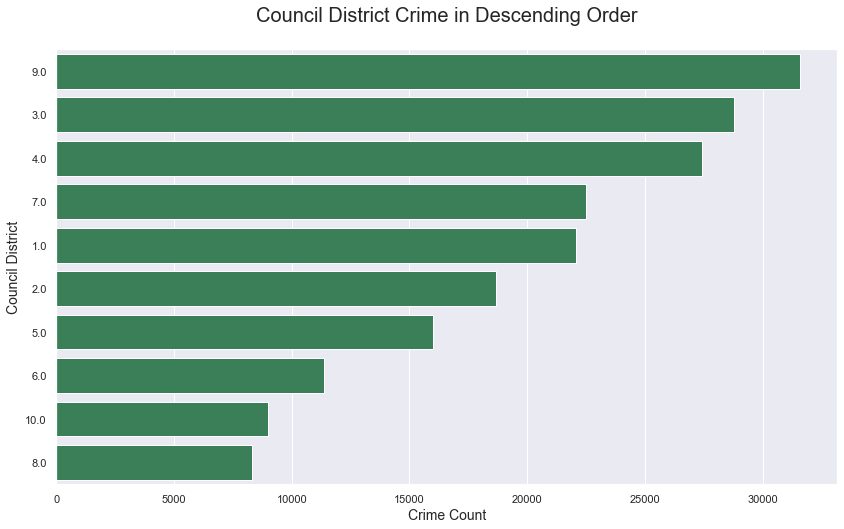

In [111]:
def council_district_crime(train):
    '''
    This function will take in the train dataset and return a seaborn 
    visual of the council district and their crime count in descending order
    '''
    ax = sns.countplot(data = train, y = 'council_district',order = train['council_district'].value_counts(ascending = False).index, color = 'seagreen')
    plt.xlabel('Crime Count',fontsize=14)# set up the x axis. 
    plt.ylabel('Council District',fontsize=14)# set up the y axis
    plt.title('Council District Crime in Descending Order\n',fontsize=20) # set up the title.
    plt.show()

    return

council_district_crime(train)

In [68]:
df1

,cleared
8,0.138138
6,0.146888
10,0.145172
5,0.175784
7,0.176267
2,0.210022
1,0.217910
3,0.243253
4,0.249581
9,0.251804


In [18]:
train.district.value_counts()

2     38903
1     36850
3     23674
4     23473
5     19964
7     19535
6     18533
8     13379
S       686
88      329
D       218
A        79
B        71
P        52
C        18
Name: district, dtype: int64

In [130]:
def district_crime(train):
    """
    This function is to create a visual to show all districts in descending order. 
    """
    # creating district crime frequency (horizontal)

    train.district.value_counts(ascending = True, normalize = False).plot.barh(color = 'orange',figsize = (12, 7))
    # adding title
    plt.xlabel('Crime Count',fontsize=12)# set up the x axis. 
    plt.ylabel('District',fontsize=12)# set up the y axis
    plt.title('District Crime in Descending Order\n',fontsize=15) # set up the title.
    plt.show()


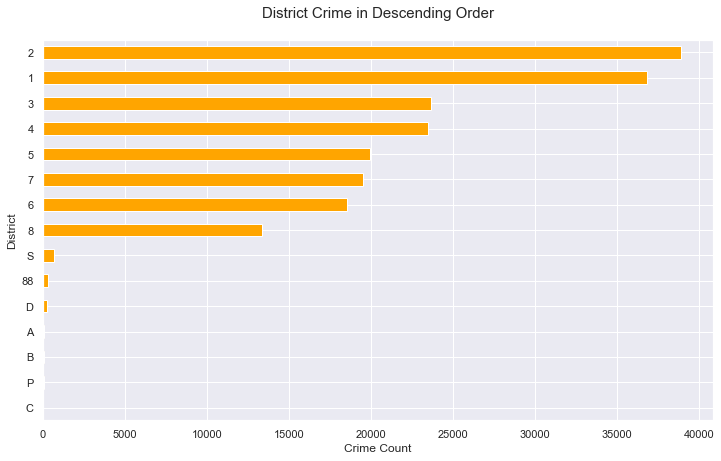

In [131]:
district_crime(train)

In [159]:
train[train.crime_type == 'MURDER'].value_counts().sum()

77

In [139]:
train.groupby('district').cleared.value_counts()

district  cleared
1         False      28570
          True        8280
2         False      28772
          True       10131
3         False      18983
          True        4691
4         False      18717
          True        4756
5         False      15904
          True        4060
6         False      15252
          True        3281
7         False      16340
          True        3195
8         False      10852
          True        2527
88        False        215
          True         114
A         True          43
          False         36
B         False         57
          True          14
C         False         13
          True           5
D         False        177
          True          41
P         False         31
          True          21
S         False        403
          True         283
Name: cleared, dtype: int64

In [34]:
top_10_crimes = ['DWI', 'ASSAULT WITH INJURY', 'THEFT BY SHOPLIFTING', 'HARASSMENT', 
                 'AUTO THEFT', 'ASSAULT W/INJURY-FAM/DATE VIOL', 'CRIMINAL MISCHIEF', 
                 'FAMILY DISTURBANCE', 'THEFT', 'BURGLARY OF VEHICLE']
# Create a subsetted df that only includes the top 10 crimes
top_crimes_df = train.copy()
top_crimes_df = top_crimes_df[top_crimes_df.crime_type.isin(top_10_crimes)]

In [33]:
def top_crime(top_crimes_df):
    """
    This function is to create a visual to show all districts in descending order. 
    """
    # creating district crime frequency (horizontal)

    top_crimes_df.council_district.value_counts(ascending = True, normalize = False).plot.barh(color = 'blue',figsize = (12, 7))
    # adding title
    plt.xlabel('Crime Count',fontsize=12)# set up the x axis. 
    plt.ylabel('Council District',fontsize=12)# set up the y axis
    plt.title('Council District Crime in Descending Order\n',fontsize=15) # set up the title.
    plt.show()

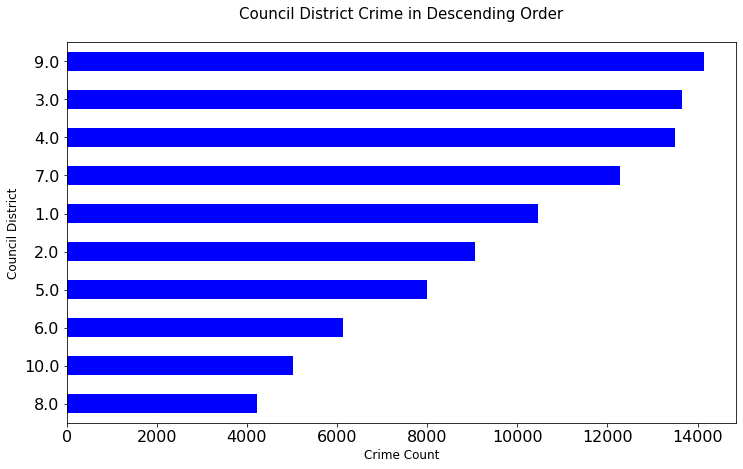

In [35]:
top_crime(top_crimes_df)

### Takeaway
- It seems that districts 9, 3 and 4 are much higher in crime compared to the other districts

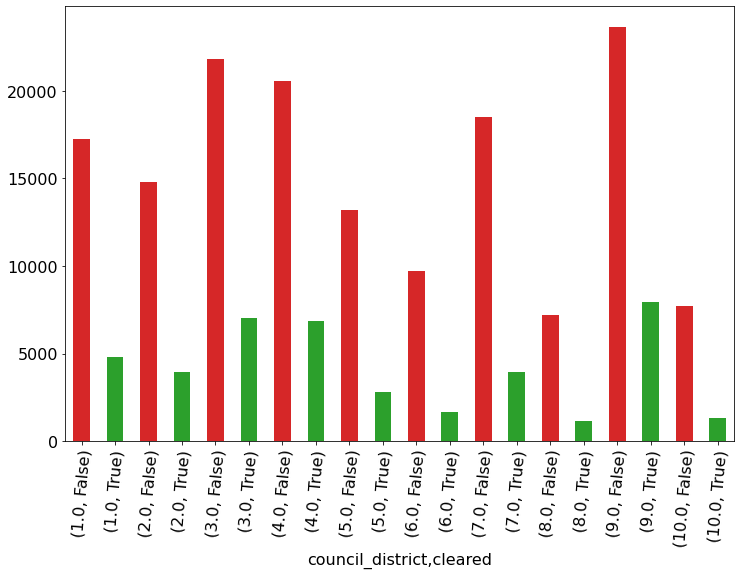

In [36]:
train.groupby('council_district').cleared.value_counts().plot.bar(figsize = (12, 8), color = ['#d62728', '#2ca02c'])
plt.tick_params('x' ,rotation = 85)

In [37]:
train.head()

,crime_type,family_violence,occurrence_time,occurrence_date,report_time,report_date,location_type,address,zip_code,council_district,sector,district,latitude,longitude,clearance_status,clearance_date,cleared
128272,IDENTITY THEFT,N,2020-12-29 18:30:00,2020-12-29,2020-12-30 01:46:00,2020-12-30,RESIDENCE / HOME,504 ARBOR LN,78745.0,3.0,DA,3,30.210307,-97.779062,not cleared,2020-12-30,False
420369,POSS CONTROLLED SUB/NARCOTIC,N,2018-03-03 01:47:00,2018-03-03,2018-03-03 01:47:00,2018-03-03,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,404 E 6TH ST,78701.0,9.0,GE,2,30.267321,-97.738933,cleared by arrest,2018-05-05,True
79483,BURGLARY OF VEHICLE,N,2021-07-05 00:00:00,2021-07-05,2021-07-06 19:54:00,2021-07-06,RESIDENCE / HOME,2200 PANTHER TRL,78704.0,5.0,DA,4,30.237971,-97.786882,not cleared,2021-07-15,False
430217,INTERFERENCE PUBLIC DUTIES,N,2018-01-25 17:24:00,2018-01-25,2018-01-31 17:24:00,2018-01-31,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,2200 W SLAUGHTER LN,78748.0,5.0,FR,1,30.174079,-97.827130,cleared by arrest,2018-01-31,True
280218,BURGLARY OF VEHICLE,N,2019-07-10 18:15:00,2019-07-10,2019-07-11 09:49:00,2019-07-11,PARKING /DROP LOT/ GARAGE,121 PICKLE RD,78704.0,3.0,DA,2,30.227295,-97.763052,not cleared,2019-07-16,False


In [38]:
def lower_zipcode_crime(train):
    """
    This function is to create a visual to show all districts in descending order. 
    """
    # creating district crime frequency (horizontal)

    train.zip_code.value_counts(ascending = True, normalize = False).tail(10).plot.barh(color = 'red',figsize = (12, 7))
    # adding title
    plt.xlabel('Crime Count',fontsize=12)# set up the x axis. 
    plt.ylabel('Zipcode',fontsize=12)# set up the y axis
    plt.title('Highest Reported Zipcodes\n',fontsize=15) # set up the title.
    plt.show()

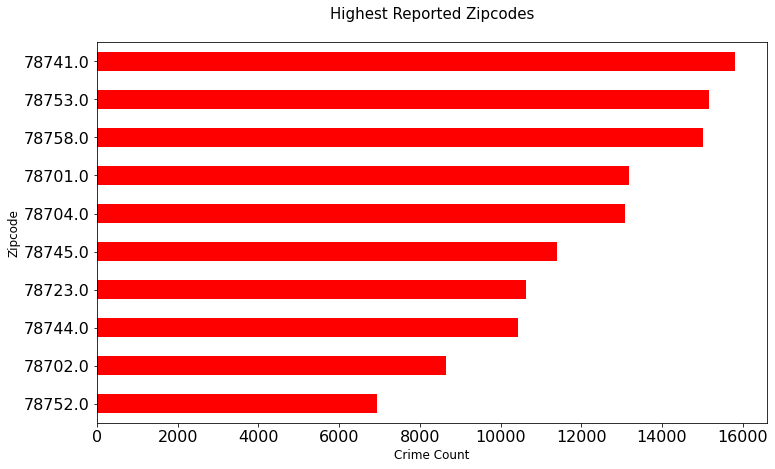

In [39]:
lower_zipcode_crime(train)

In [40]:
def upper_zipcode_crime(train):
    """
    This function is to create a visual to show top 10 safest zipcodes in descending order. 
    """
    # creating district crime frequency (horizontal)

    train.zip_code.value_counts(ascending = True, normalize = False).head(10).plot.barh(color = 'green',figsize = (12, 7))
    # adding title
    plt.xlabel('Crime Count',fontsize=12)# set up the x axis. 
    plt.ylabel('Zipcode',fontsize=12)# set up the y axis
    plt.title('Least Reported Zipcodes\n',fontsize=15) # set up the title.
    plt.show()

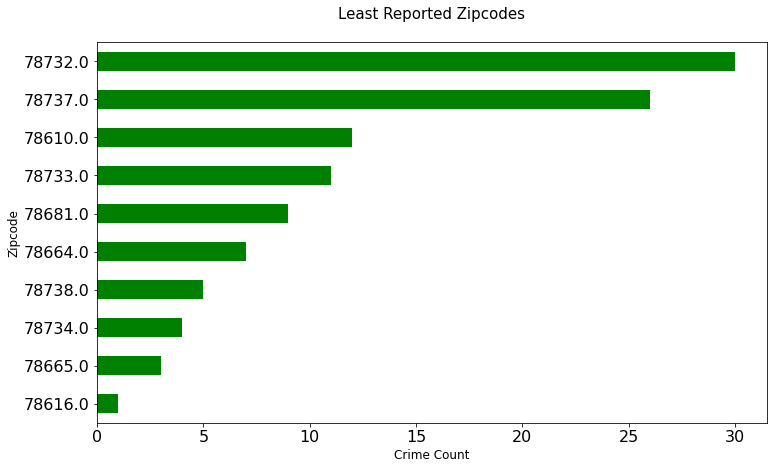

In [41]:
upper_zipcode_crime(train)

<AxesSubplot:xlabel='council_district'>

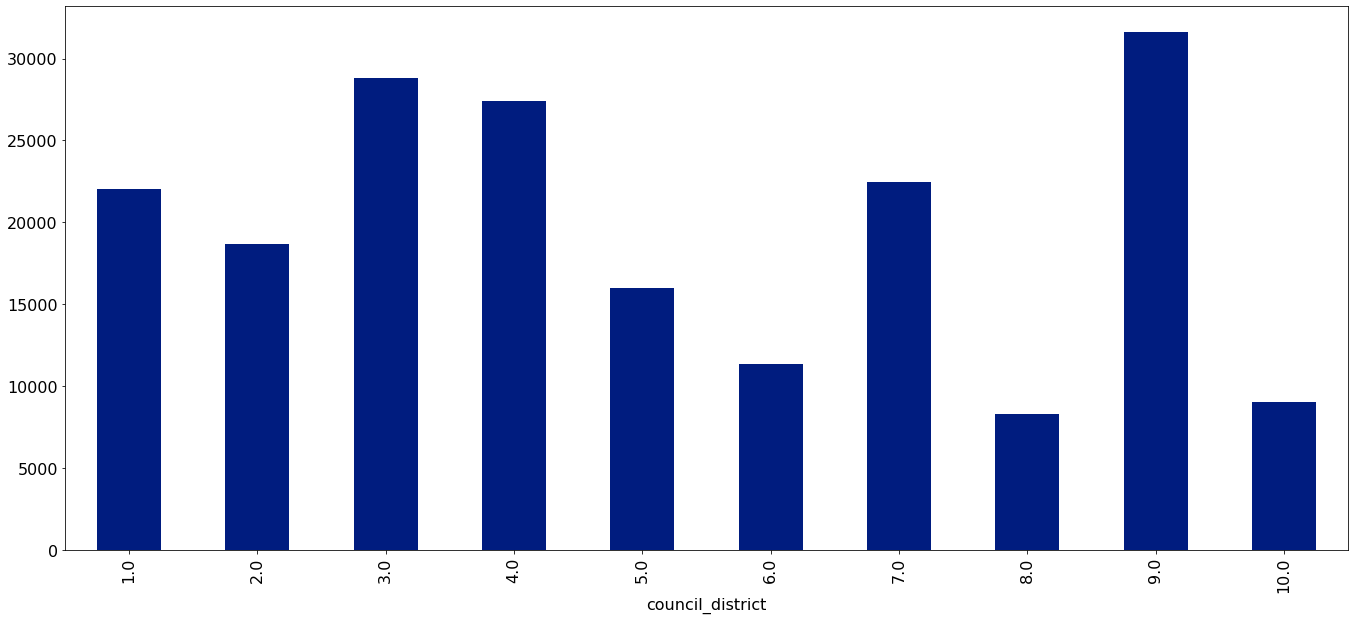

In [45]:
train.groupby(train.council_district).crime_type.count().plot.bar()

hard to solve
- family disturbance
- disturbance


more solvable
- auto theft (possible)
- assault with injury
- dwi
- 

topics of discussion
- hardening targets ( proper lighting, dog in yard )

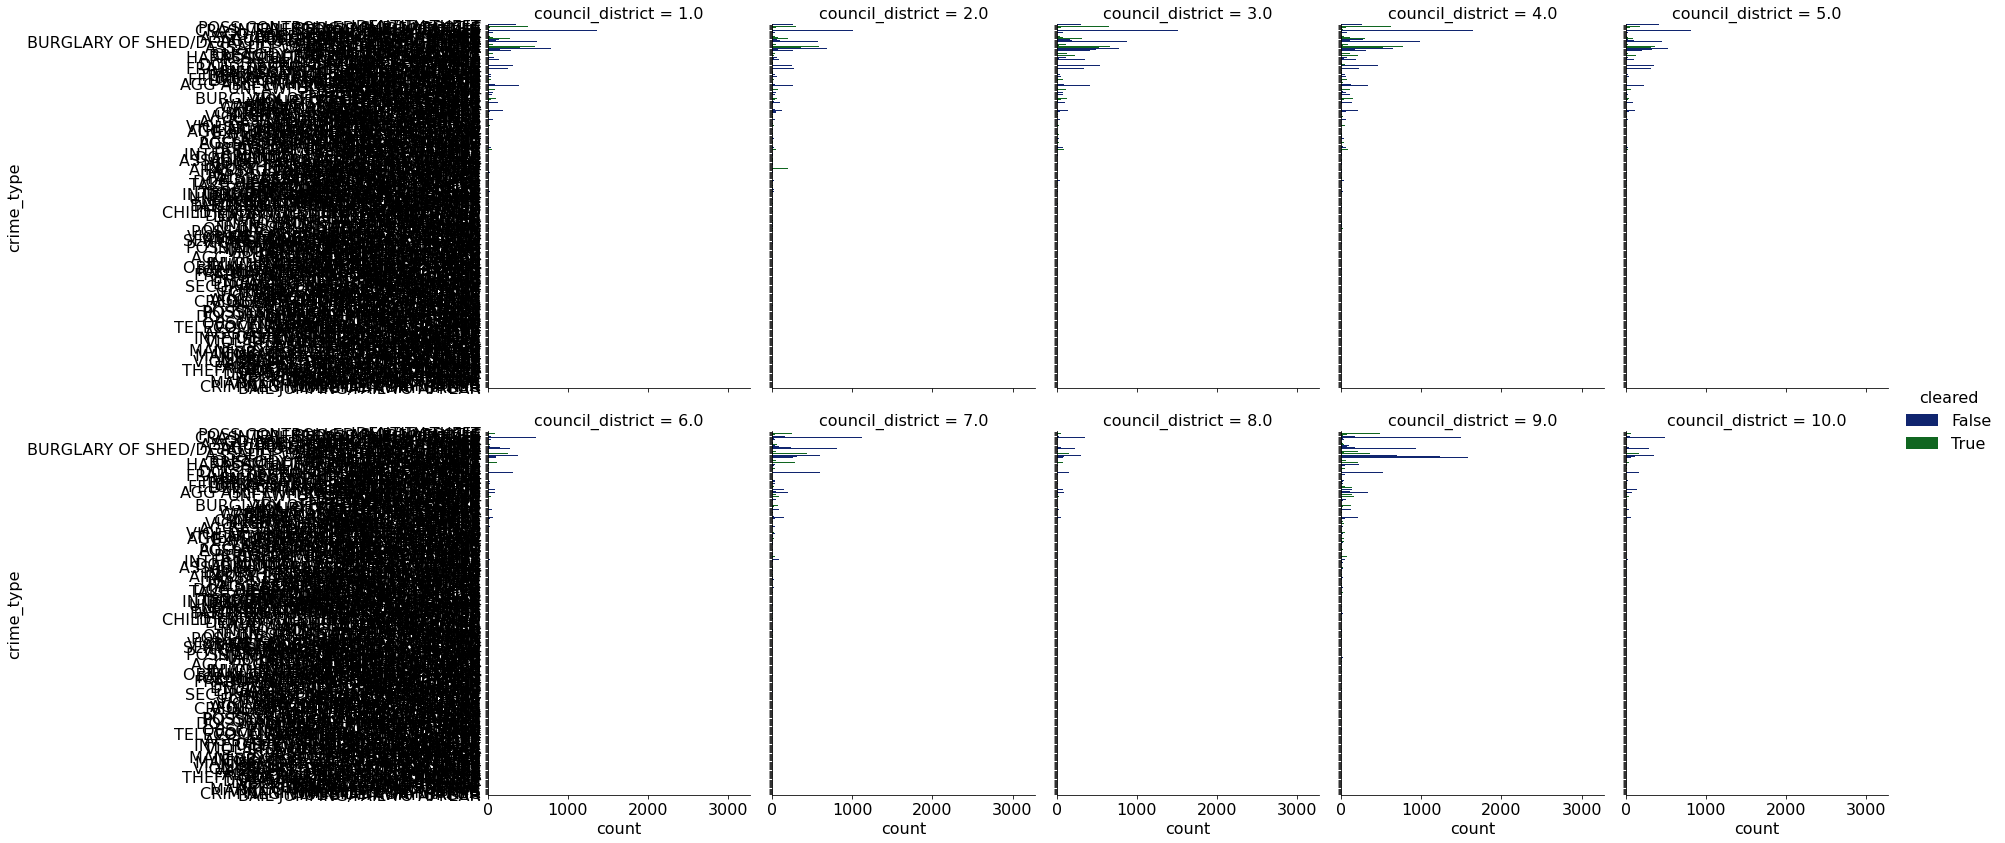

In [17]:
#define plotting region (2 rows, 5 columns)
# fig, axes = plt.subplots(2, 5)

sns.catplot(y="crime_type", hue="cleared", col="council_district",
              data=train, kind="count",
                height=6, aspect=.9, col_wrap = 5);

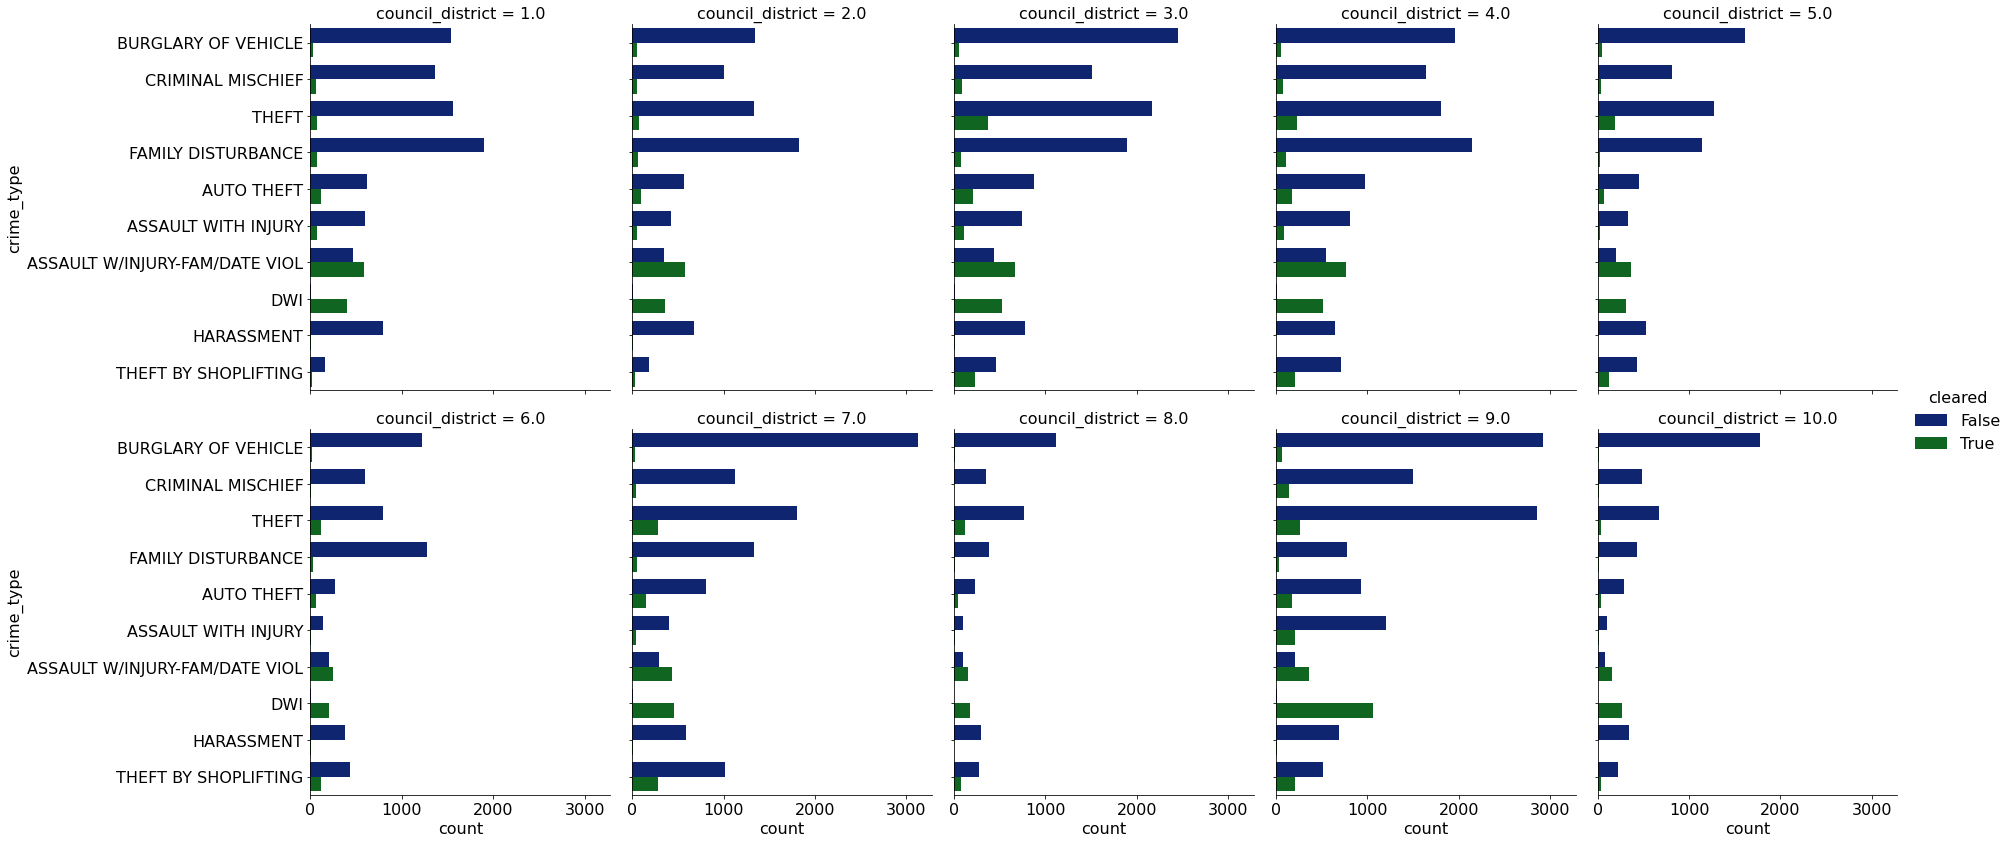

In [46]:
#define plotting region (2 rows, 5 columns)
# fig, axes = plt.subplots(2, 5)

sns.catplot(y="crime_type", hue="cleared", col="council_district",
              data=top_crimes_df, kind="count",
                height=6, aspect=.9, col_wrap = 5);


In [182]:
train.groupby('council_district').cleared.value_counts()

council_district  cleared
1.0               False      17249
                  True        4806
2.0               False      14771
                  True        3927
3.0               False      21786
                  True        7003
4.0               False      20575
                  True        6843
5.0               False      13199
                  True        2815
6.0               False       9705
                  True        1671
7.0               False      18520
                  True        3963
8.0               False       7175
                  True        1150
9.0               False      23640
                  True        7956
10.0              False       7702
                  True        1308
Name: cleared, dtype: int64

In [102]:
train.cleared.mean()

0.2116936719723749

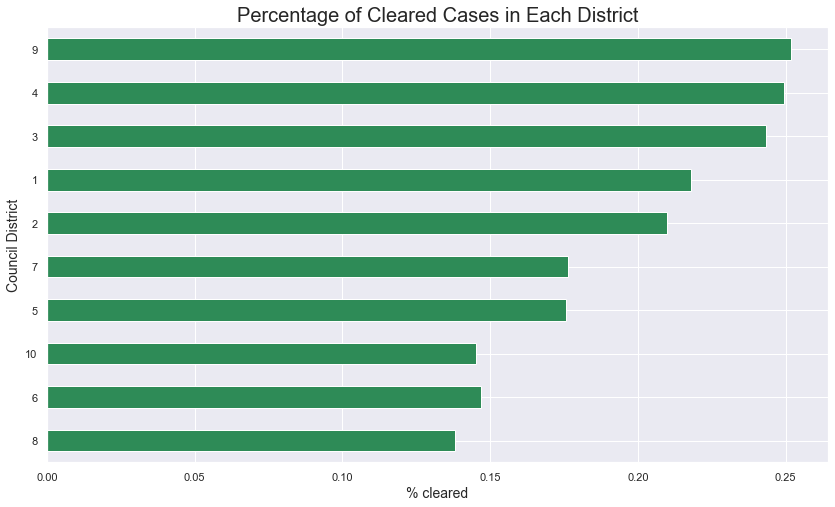

In [127]:
def district_cleared(train):
    index = [8,6,10,5,7,2,1,3,4,9]
    df1 = pd.DataFrame(train.groupby('council_district').cleared.mean(), index = index)
    ax = df1.plot.barh(color = 'seagreen')
    plt.ylabel('Council District', fontsize = 14)
    plt.xlabel('% cleared', fontsize = 14)
    plt.title('Percentage of Cleared Cases in Each District', fontsize = 20)
    ax.get_legend().remove()
    return 
district_cleared(train)

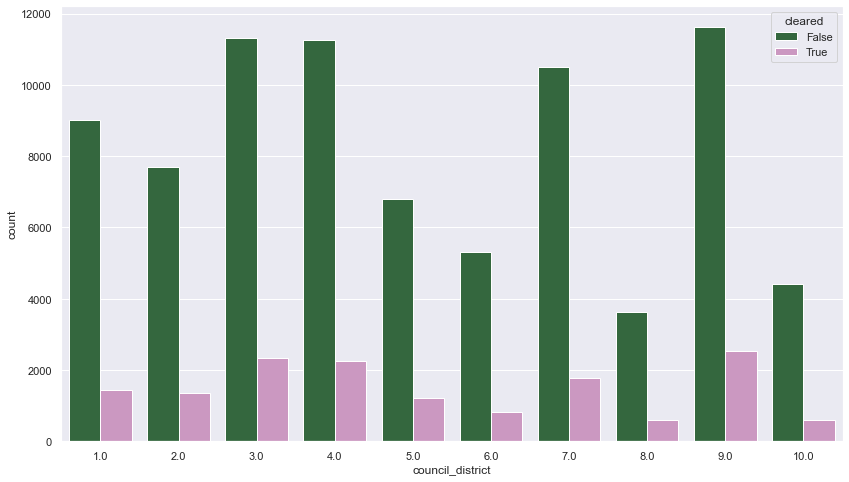

In [96]:
def top_crime_per_district_cleared(train):
    sns.countplot(data = top_crimes_df, x = 'council_district', hue = 'cleared', palette = 'cubehelix')
    sns.set(rc={'figure.figsize':(14, 8)})
    return
top_crime_per_district_cleared(train)

In [50]:
overall_sample = train.groupby('council_district').council_district.count().mean()
nine_sample = train[train.council_district == 9].counts
eight_sample = train[train.council_district == 8].counts
overall_sample, nine_sample, eight_sample

(19576.4,
 420369    31596
 222259    31596
 110705    31596
 189993    31596
 122455    31596
           ...  
 152773    31596
 420198    31596
 85848     31596
 244370    31596
 179543    31596
 Name: counts, Length: 31596, dtype: int64,
 405183    8325
 86729     8325
 91399     8325
 348376    8325
 201988    8325
           ... 
 431622    8325
 83844     8325
 376478    8325
 335019    8325
 309511    8325
 Name: counts, Length: 8325, dtype: int64)

### District 9 one sample ttest

- H0: The average caseload in District 9 <= The average caseload of cases of ALL Districts
- Ha: The average caseload in District 9 > The average caseload of cases of ALL Districts

In [51]:
alpha = .05
t, p = stats.ttest_1samp(nine_sample, overall_sample)

print(t, p/2, alpha)

inf 0.0 0.05


In [52]:
if p/2 > alpha:
    print("We fail to reject Null Hypothesis")
elif t < 0:
    print("We fail to reject Null Hypothesis")
else:
    print("We reject Null Hypothesis")

We reject Null Hypothesis


### District 8 one sample ttest

- H0: The average caseload in District 8 >= The average caseload of cases of ALL Districts
- Ha: The average caseload in District 8 < The average caseload of cases of ALL Districts

In [53]:
alpha = .05
t, p = stats.ttest_1samp(eight_sample, overall_sample)

print(t, p/2, alpha)

-inf 0.0 0.05


In [54]:
if p/2 > alpha:
    print("We fail to reject Null Hypothesis")
elif t > 0:
    print("We fail to reject Null Hypothesis")
else:
    print("We reject Null Hypothesis")

We reject Null Hypothesis


# Zipcodes